In [24]:
import numpy as np # algebra liniowa
import matplotlib.pyplot as plt # używane do rysowania wykresów
from sklearn.datasets import load_digits # importowanie zbioru danych
from sklearn.model_selection import train_test_split # podział danych na część treningową i testową
from sklearn.preprocessing import MinMaxScaler # normalizacja danych
from sklearn.preprocessing import OneHotEncoder # kodowanie one-hot
import optuna # do hiperparametryzacji
import warnings # ignorowanie ostrzeżeń
warnings.filterwarnings("ignore")


In [25]:
image_size = (64, 64)

def load_train_data(input_dir, newSize=(64,64)):
    '''
    '''

    
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json


    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib
    
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255#normalizacja
                train_img.append(img)
        categories_count.append(count)
    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

In [26]:
class MyNeuralNetwork:

    def __init__(self, input_size: int, hidden_size: int, output_size: int, loss_func='mse'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.loss_func = loss_func

        # initialize weights and biases:
        self.weights1 = np.random.randn(self.input_size, self.hidden_size)
        self.bias1 = np.zeros((1, self.hidden_size))
        self.weights2 = np.random.randn(self.input_size, self.hidden_size)
        self.bias2 = np.zeros((1, self.output_size))

        # watch losses:
        self.train_loss = []
        self.test_loss = []

    def __str__(self):
        return f'input layer size: {self.input_size}, hidden layer size: {self.hidden_size}, output size: {self.output_size}. Loss function: {self.loss_func}'
    
    def forward_propagation(self, x):
        self.z1 = np.dot(x, self.weights1) + self.bias1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        if self.loss_func == 'categorical_crossentrophy':
            self.a2 = self.softmax(self.z2)
        else:
            self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def backward_propagation(self, x, y, learning_rate):
        m = x.shape[0]

        # gradients
        if self.loss_func == 'mse':
            self.dz2 = self.a2 - y
        elif self.loss_func == 'log_loss':
            self.dz2 = -(y/self.a2 - (1-y)/(1-self.a2))
        elif self.loss_func == 'categorical_crossentropy':
            self.dz2 = self.a2 - y
        else:
            raise ValueError('Not valid loss function! That ain\'t work')

        # calculate new weights                   
        self.dw2 = (1/m) * np.dot(self.a1.T, self.dz2)
        self.db2 =(1/m) * np.sum(self.dz2, axis=0, keepdims=True)
        self.dz1 = np.dot(self.dz2, self.weight2.T) * self.sigmoid_derivative(self.a1)
        self.dw1 = (1/m) * np.dot(x.T, self.dz1)
        self.db1 = (1/m) * np.sum(self.dz1, axis=0, keepdims=True)

        # update weights and biases
        self.weights2 -= learning_rate * self.dw2
        self.bias2 -= learning_rate * self.db2
        self.weights1 -= learning_rate * self.dw1
        self.bias1 -= learning_rate * self.db1

    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1-x)
    
    def softmax(self, x):
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps/np.sum(exps, axis=1, keepdims=True)


In [27]:
class Trainer:
    def __init__(self, model, loss_func='mse'):
        self.model = model
        self.loss_func = loss_func
        self.train_loss = []
        self.test_loss = []

    def calculate_loss(self, y_true, y_pred):
        if self.loss_func == 'mse':
            return np.mean((y_pred - y_true)**2)
        elif self.loss_func == 'log_loss':
            return -np.mean(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))
        elif self.loss_func == 'categorical_crossentropy':
            return -np.mean(y_true*np.log(y_pred))
        else:
            raise ValueError('Nieprawidłowa funkcja straty')

    def train(self, x_train, y_train, X_test, y_test, epochs, learning_rate):
        for _ in range(epochs):
            self.model.forward_propagation(x_train)
            self.model.backward_propagation(x_train, y_train, learning_rate)
            train_loss = self.calculate_loss(y_train, self.model.a2)
            self.train_loss.append(train_loss)
            
            self.model.forward_propagation(X_test)
            test_loss = self.calculate_loss(y_test, self.model.a2)
            self.test_loss.append(test_loss)

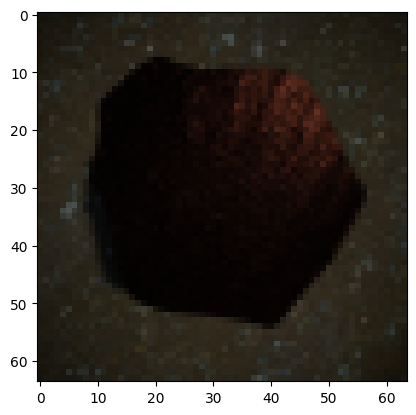

In [35]:
# load train data
train_data = load_train_data('./train_test_sw/train_sw')

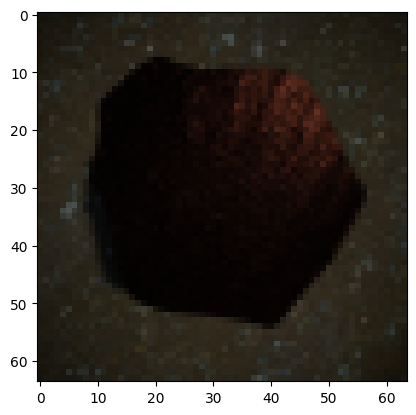

In [36]:
plt.imshow(train_data['values'][0])

In [93]:
# enhance data function
def enhance_train_data(images, image_size=(64, 64)):
   augmented_images = []

   for i in images:
        augmented_images.append(i)
        for _ in range(10):
           augmented = augment(i, image_size)
           augmented_images.append(augmented)
   
   return augmented_images


def augment(image, image_size=(64,64)):
    import tensorflow as tf
    delta = 0.09 # maximum relative change in brigtness
    
    image = tf.cast(image, tf.float32)
    image = tf.image.random_crop(image, size=[image_size[0], image_size[1], 3])
    image = tf.image.random_brightness(image, delta)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.8, 1.2)

    return image

In [94]:
# enhance data
data_to_enhance = train_data["values"]
augmented_images = enhance_train_data(data_to_enhance, image_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


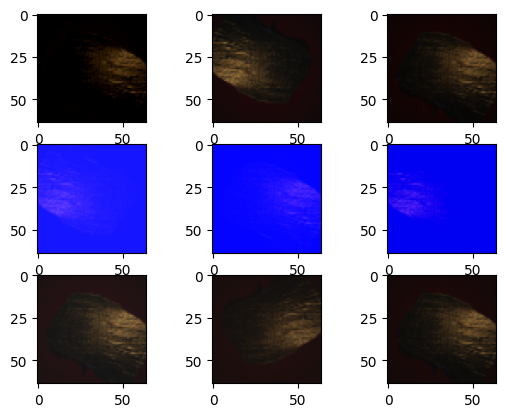

In [95]:
# testing purposes only:
for i in range(9):
  index = i + 100
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[index])


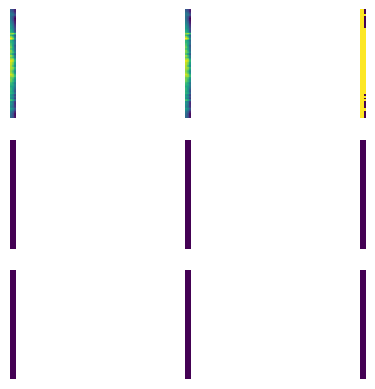

In [40]:
for i in range(9):
  augmented_image = augmented_images[i]
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
# Prooces data:

In [ ]:
# Utwórz instancję klasy NeuralNetwork
rozmiar_wejscia = X.shape[1]
rozmiar_warstwy_ukrytej = 64
rozmiar_wyjscia = len(np.unique(y))
funkcja_straty = 'categorical_crossentropy'
epoki = 1000
wspolczynnik_uczenia = 0.1

nn = MyNeuralNetwork(rozmiar_wejscia, rozmiar_warstwy_ukrytej, rozmiar_wyjscia, funkcja_straty)

# Wyświetl architekturę sieci neuronowej
print(nn)

NameError: name 'X' is not defined

In [ ]:
trener = Trainer(nn, funkcja_straty)
trener.train(X_train, y_train, X_test, y_test, epoki, wspolczynnik_uczenia)

# Przekonwertuj y_test z kodowania one-hot na etykiety
etykiety_y_test = np.argmax(y_test, axis=1)

# Oceń wydajność sieci neuronowej
prognozy = np.argmax(nn.forward_propagation(X_test), axis=1)
dokladnosc = np.mean(prognozy == etykiety_y_test)
print(f"Dokładność: {dokladnosc:.2%}")

ValueError: operands could not be broadcast together with shapes (1437,64) (1,10) 